# 🎯 K-Means Clustering Analysis

This notebook performs **K-Means clustering** on supplier performance data to identify distinct supplier groups.

## 🎯 What is K-Means?

- **Partitioning Algorithm**: Divides data into k distinct clusters

- **Centroid-based**: Each cluster represented by its center point

- **Iterative**: Updates centroids until convergence

- **Best for**: Spherical, well-separated clusters


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import warnings
import os
from datetime import datetime

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
def load_cleaned_data(file_path='../data/processed/cleaned_data.csv'):
    """Load the cleaned supplier data for clustering"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Cleaned data file not found: {file_path}")
        
    print(f"Loading cleaned data from {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df):,} rows with {len(df.columns)} columns")
    
    # Basic info
    print(f"\nDataset overview:")
    print(f"   • Unique suppliers: {df['supplier_id'].nunique()}")
    print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"   • Performance score range: {df['overall_score'].min():.1f} - {df['overall_score'].max():.1f}")
    
    return df

# Load the data
df = load_cleaned_data()

# Show sample data
print("\nSample data (first 3 rows):")
df.head(3)

Loading cleaned data from ../data/processed/cleaned_data.csv
Loaded 2,994 rows with 21 columns

Dataset overview:
   • Unique suppliers: 25
   • Date range: 2015-01-01 to 2024-12-01
   • Performance score range: 39.8 - 87.0

Sample data (first 3 rows):


,date,year,month,quarter,supplier_id,company_name,company_size,industry,location,delivery_reliability,...,defect_rate,quality_score,on_time_delivery_rate,order_volume,response_time_hours,customer_satisfaction,overall_score,performance_category,defect_cost_impact,efficiency_ratio
0,2015-01-01,2015,1,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,78.844749,...,1.362205,86.623620,75.458909,316.0,21.961844,7.926791,79.83,Good,21522.84,1.306
1,2015-02-01,2015,2,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,75.012850,...,1.026724,84.857776,75.355035,352.0,22.700895,7.965200,79.27,Good,18070.35,1.267
2,2015-03-01,2015,3,Q1,SUP_001,Fowler Corp,Medium,Machinery,Europe,71.885296,...,0.325915,83.383238,74.145862,273.0,22.536271,7.667606,79.22,Good,4448.74,1.245


In [3]:
def prepare_clustering_features(df):
    """Prepare and select features for K-Means clustering"""    
    # Select key performance features for clustering
    # These represent the core supplier performance dimensions
    clustering_features = [
        'delivery_reliability',     # How reliable are deliveries?
        'cost_efficiency',          # How cost-effective?
        'defect_rate',              # Quality indicator (lower is better)
        'quality_score',            # Overall quality rating
        'on_time_delivery_rate',    # Punctuality
        'response_time_hours',      # Customer service speed (lower is better)
        'customer_satisfaction'     # Customer happiness
    ]
    
    print(f"Selected {len(clustering_features)} features for clustering:")
    for i, feature in enumerate(clustering_features, 1):
        print(f"   {i}. {feature}")
    
    # Extract feature matrix
    X = df[clustering_features].values
    print(f"\nOriginal feature matrix shape: {X.shape}")
    
    # Standardize features (important for K-Means)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("Features standardized (mean=0, std=1)")
    print(f"Scaled feature matrix shape: {X_scaled.shape}")
    
    # Show feature statistics after scaling
    print("\nFeature statistics after scaling:")
    scaled_df = pd.DataFrame(X_scaled, columns=clustering_features)
    stats = scaled_df.describe().round(3)
    print(stats)
    
    # Check for any remaining issues
    if np.isnan(X_scaled).any():
        print("Warning: NaN values found after scaling")
    else:
        print("No NaN values in scaled data")
    
    return X_scaled, scaler, clustering_features, df

# Prepare features
X_scaled, scaler, clustering_features, df_original = prepare_clustering_features(df)

Selected 7 features for clustering:
   1. delivery_reliability
   2. cost_efficiency
   3. defect_rate
   4. quality_score
   5. on_time_delivery_rate
   6. response_time_hours
   7. customer_satisfaction

Original feature matrix shape: (2994, 7)
Features standardized (mean=0, std=1)
Scaled feature matrix shape: (2994, 7)

Feature statistics after scaling:
       delivery_reliability  cost_efficiency  defect_rate  quality_score  \
count              2994.000         2994.000     2994.000       2994.000   
mean                 -0.000            0.000       -0.000         -0.000   
std                   1.000            1.000        1.000          1.000   
min                  -2.959           -2.075       -1.486         -1.447   
25%                  -0.535           -0.731       -0.686         -0.942   
50%                  -0.077            0.114       -0.160         -0.125   
75%                   0.658            0.852        0.442          0.885   
max                   2.541      

Testing different cluster numbers...
   k=2: inertia=16,551
   k=3: inertia=13,212
   k=4: inertia=11,453
   k=5: inertia=9,749
   k=6: inertia=8,811
   k=7: inertia=7,983
   k=8: inertia=7,148


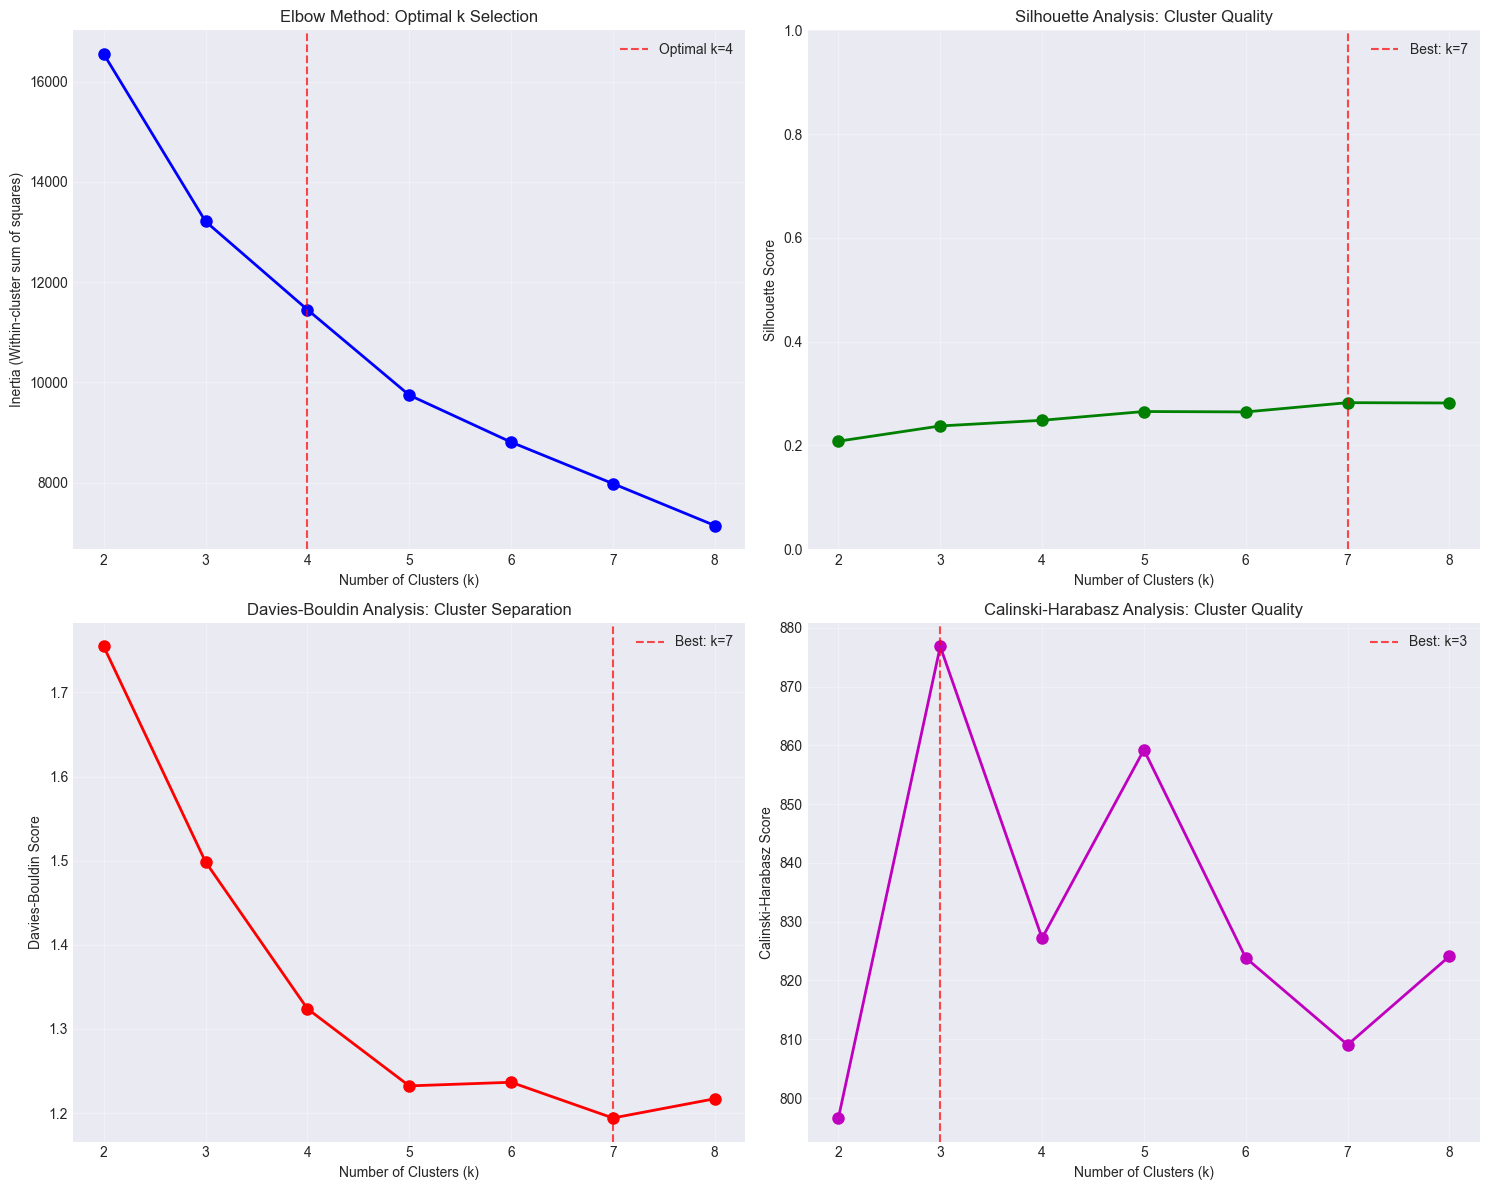


Recommended number of clusters: k=5
   • Elbow method suggests: k=4
   • Best silhouette score: k=7 (score: 0.282)
   • Best Davies-Bouldin score: k=7 (score: 1.194)
   • Best Calinski-Harabasz score: k=3 (score: 876.824)
   • Final choice: k=5 (balanced approach using all metrics)


In [4]:
def find_optimal_clusters(X_scaled, max_clusters=8):
    """Use elbow method to find optimal number of clusters"""
    # Test different numbers of clusters
    k_range = range(2, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    davies_bouldin_scores = []
    calinski_harabasz_scores = []
    
    print("Testing different cluster numbers...")
    
    for k in k_range:
        # Fit K-Means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        # Store metrics
        inertias.append(kmeans.inertia_)
        
        # Calculate silhouette score (measure of cluster quality)
        if k > 1:  # Silhouette score needs at least 2 clusters
            silhouette = silhouette_score(X_scaled, kmeans.labels_)
            silhouette_scores.append(silhouette)
            
            # Calculate Davies-Bouldin score (lower is better)
            davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)
            davies_bouldin_scores.append(davies_bouldin)
            
            # Calculate Calinski-Harabasz score (higher is better)
            calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans.labels_)
            calinski_harabasz_scores.append(calinski_harabasz)
        
        print(f"   k={k}: inertia={kmeans.inertia_:,.0f}")
    
    # Create elbow plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Elbow plot
    ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
    ax1.set_title('Elbow Method: Optimal k Selection')
    ax1.grid(True, alpha=0.3)
    
    # Add elbow point annotation (approximate)
    # The "elbow" is typically around k=4-5 for supplier data
    elbow_k = 4  # Based on typical supplier segmentation
    ax1.axvline(x=elbow_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={elbow_k}')
    ax1.legend()
    
    # Silhouette score plot
    ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis: Cluster Quality')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Highlight best silhouette score
    best_k = k_range[np.argmax(silhouette_scores)]
    ax2.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: k={best_k}')
    ax2.legend()
    
    # Davies-Bouldin score plot
    ax3.plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
    ax3.set_xlabel('Number of Clusters (k)')
    ax3.set_ylabel('Davies-Bouldin Score')
    ax3.set_title('Davies-Bouldin Analysis: Cluster Separation')
    ax3.grid(True, alpha=0.3)
    
    # Highlight best Davies-Bouldin score
    best_db_k = k_range[np.argmin(davies_bouldin_scores)]
    ax3.axvline(x=best_db_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: k={best_db_k}')
    ax3.legend()
    
    # Calinski-Harabasz score plot
    ax4.plot(k_range, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
    ax4.set_xlabel('Number of Clusters (k)')
    ax4.set_ylabel('Calinski-Harabasz Score')
    ax4.set_title('Calinski-Harabasz Analysis: Cluster Quality')
    ax4.grid(True, alpha=0.3)
    
    # Highlight best Calinski-Harabasz score
    best_ch_k = k_range[np.argmax(calinski_harabasz_scores)]
    ax4.axvline(x=best_ch_k, color='red', linestyle='--', alpha=0.7, 
                label=f'Best: k={best_ch_k}')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../data/results/kmeans_elbow_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Recommend optimal k based on all metrics
    suggested_ks = [elbow_k, best_k, best_db_k, best_ch_k]
    optimal_k = int(np.round(np.mean(suggested_ks)))  # Average of all suggestions
    
    print(f"\nRecommended number of clusters: k={optimal_k}")
    print(f"   • Elbow method suggests: k={elbow_k}")
    print(f"   • Best silhouette score: k={best_k} (score: {max(silhouette_scores):.3f})")
    print(f"   • Best Davies-Bouldin score: k={best_db_k} (score: {min(davies_bouldin_scores):.3f})")
    print(f"   • Best Calinski-Harabasz score: k={best_ch_k} (score: {max(calinski_harabasz_scores):.3f})")
    print(f"   • Final choice: k={optimal_k} (balanced approach using all metrics)")
    
    return optimal_k

# Find optimal number of clusters
optimal_k = find_optimal_clusters(X_scaled)

In [5]:
def apply_kmeans_clustering(X_scaled, n_clusters, df_original):
    """Apply K-Means clustering with the optimal number of clusters"""
    print(f"Clustering {len(X_scaled):,} data points into {n_clusters} clusters")
    
    # Apply K-Means
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10,  # Run multiple times to find best result
        init='k-means++'  # Smart initialization
    )
    
    # Fit and predict
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    print("K-Means clustering completed!")
    
    # Add cluster labels to original data
    df_clustered = df_original.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Add descriptive cluster names
    cluster_names = {
        0: 'High Performers',
        1: 'Cost Efficient',
        2: 'Quality Focused',
        3: 'Needs Improvement'
    }
    
    df_clustered['cluster_name'] = df_clustered['cluster'].map(cluster_names)
    
    # Show cluster distribution
    print("\nCluster Distribution:")
    cluster_counts = df_clustered['cluster_name'].value_counts().sort_index()
    for cluster_name, count in cluster_counts.items():
        percentage = (count / len(df_clustered)) * 100
        print(f"   • {cluster_name}: {count:,} suppliers ({percentage:.1f}%)")
    
    # Calculate cluster centroids (centers)
    centroids = kmeans.cluster_centers_
    print(f"\nCluster centroids calculated: {centroids.shape}")
    
    # Calculate inertia (within-cluster sum of squares)
    inertia = kmeans.inertia_
    print(f"Final inertia: {inertia:,.0f}")
    
    return df_clustered, kmeans, centroids

# Apply K-Means clustering
df_clustered, kmeans_model, centroids = apply_kmeans_clustering(X_scaled, optimal_k, df)

Clustering 2,994 data points into 5 clusters
K-Means clustering completed!

Cluster Distribution:
   • Cost Efficient: 1,004 suppliers (33.5%)
   • High Performers: 494 suppliers (16.5%)
   • Needs Improvement: 731 suppliers (24.4%)
   • Quality Focused: 128 suppliers (4.3%)

Cluster centroids calculated: (5, 7)
Final inertia: 9,749


In [6]:
def analyze_cluster_characteristics(df_clustered, centroids, scaler, clustering_features):
    """Analyze the characteristics of each cluster"""   
    # Group by cluster and calculate mean performance metrics
    cluster_summary = df_clustered.groupby('cluster_name').agg({
        'delivery_reliability': 'mean',
        'cost_efficiency': 'mean',
        'defect_rate': 'mean',
        'quality_score': 'mean',
        'on_time_delivery_rate': 'mean',
        'response_time_hours': 'mean',
        'customer_satisfaction': 'mean',
        'overall_score': 'mean',
        'supplier_id': 'count'
    }).round(2)
    
    # Rename count column
    cluster_summary = cluster_summary.rename(columns={'supplier_id': 'supplier_count'})
    
    print("Cluster Performance Summary:")
    print(cluster_summary)
    
    # Create detailed cluster profiles
    print("\nDetailed Cluster Profiles:")
    print("="*60)
    
    for cluster_name in cluster_summary.index:
        stats = cluster_summary.loc[cluster_name]
        print(f"\n{cluster_name} ({stats['supplier_count']} suppliers)")
        print(f"   Overall Score: {stats['overall_score']:.1f}/100")
        print(f"   Delivery Reliability: {stats['delivery_reliability']:.1f}%")
        print(f"   Cost Efficiency: {stats['cost_efficiency']:.1f}%")
        print(f"   Defect Rate: {stats['defect_rate']:.2f}%")
        print(f"   Quality Score: {stats['quality_score']:.1f}%")
        print(f"   Customer Satisfaction: {stats['customer_satisfaction']:.1f}/10")
    
    # Calculate cluster centroids in original scale
    centroids_original = scaler.inverse_transform(centroids)
    centroids_df = pd.DataFrame(centroids_original, columns=clustering_features)
    
    print("\nCluster Centroids (Original Scale):")
    print(centroids_df.round(2))
    
    return cluster_summary, centroids_df

# Analyze cluster characteristics
cluster_summary, centroids_df = analyze_cluster_characteristics(df_clustered, centroids, scaler, clustering_features)

Cluster Performance Summary:
                   delivery_reliability  cost_efficiency  defect_rate  \
cluster_name                                                            
Cost Efficient                    61.08            52.41         1.79   
High Performers                   56.41            81.06         1.76   
Needs Improvement                 73.39            75.97         1.63   
Quality Focused                   40.56            36.92         4.73   

                   quality_score  on_time_delivery_rate  response_time_hours  \
cluster_name                                                                   
Cost Efficient             77.36                  61.17                20.45   
High Performers            50.59                  56.23                23.58   
Needs Improvement          81.35                  73.44                20.56   
Quality Focused            54.49                  40.34                20.23   

                   customer_satisfaction  overall_s

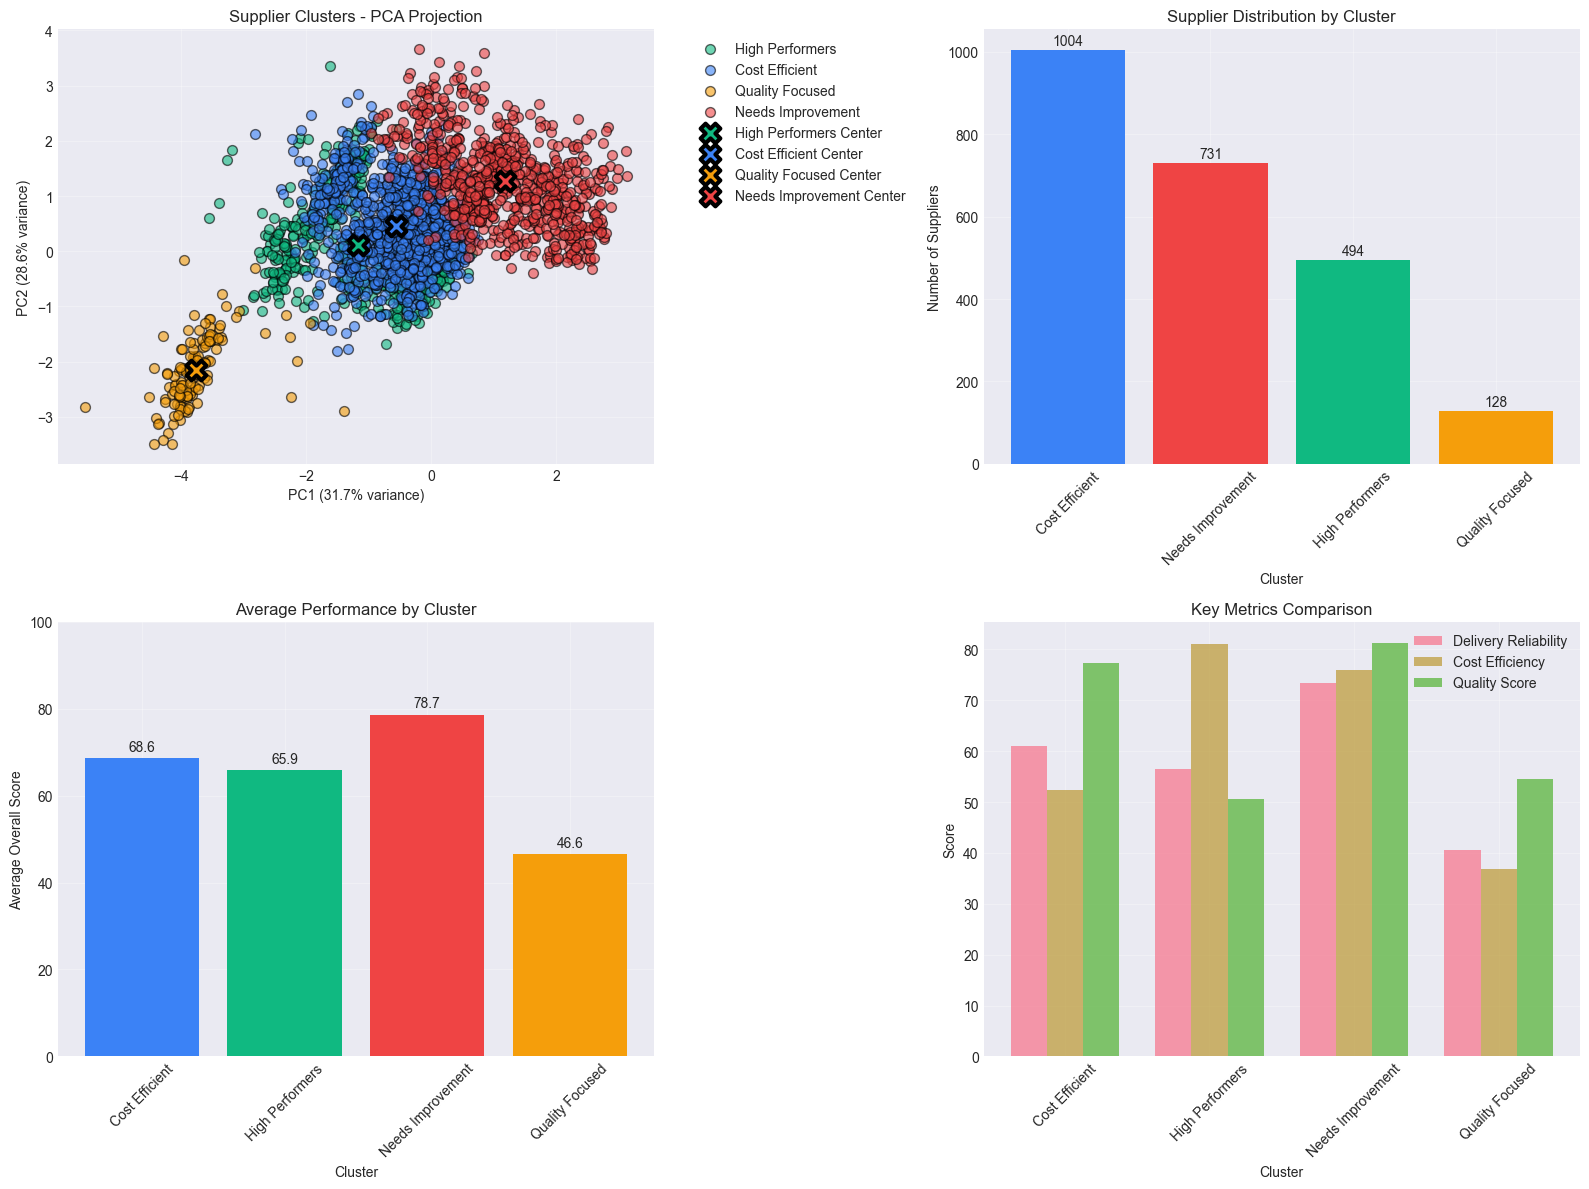

Clustering visualizations saved!


In [7]:
def visualize_clustering_results(df_clustered, X_scaled, centroids, clustering_features):
    """Create visualizations for the clustering results"""
    # Set up color scheme for clusters
    cluster_colors = {
        'High Performers': '#10B981',    # Green
        'Cost Efficient': '#3B82F6',     # Blue
        'Quality Focused': '#F59E0B',    # Orange
        'Needs Improvement': '#EF4444'   # Red
    }
    
    # 1. 2D PCA visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(16, 12))
    
    # Plot 1: PCA scatter plot
    plt.subplot(2, 2, 1)
    for cluster_name, color in cluster_colors.items():
        mask = df_clustered['cluster_name'] == cluster_name
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=color, label=cluster_name, alpha=0.6, s=50, edgecolors='black')
    
    # Plot centroids in PCA space
    centroids_pca = pca.transform(centroids)
    for i, (cluster_name, color) in enumerate(cluster_colors.items()):
        plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1], 
                   c=color, marker='X', s=200, edgecolors='black', linewidth=3,
                   label=f'{cluster_name} Center')
    
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('Supplier Clusters - PCA Projection')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Plot 2: Cluster size comparison
    plt.subplot(2, 2, 2)
    cluster_sizes = df_clustered['cluster_name'].value_counts()
    bars = plt.bar(range(len(cluster_sizes)), cluster_sizes.values, 
                   color=[cluster_colors[name] for name in cluster_sizes.index])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Suppliers')
    plt.title('Supplier Distribution by Cluster')
    plt.xticks(range(len(cluster_sizes)), cluster_sizes.index, rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, cluster_sizes.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{value}', ha='center', va='bottom')
    
    # Plot 3: Performance radar chart (simplified)
    plt.subplot(2, 2, 3)
    # Create a simple bar chart of overall scores by cluster
    overall_scores = df_clustered.groupby('cluster_name')['overall_score'].mean()
    bars = plt.bar(range(len(overall_scores)), overall_scores.values,
                   color=[cluster_colors[name] for name in overall_scores.index])
    plt.xlabel('Cluster')
    plt.ylabel('Average Overall Score')
    plt.title('Average Performance by Cluster')
    plt.xticks(range(len(overall_scores)), overall_scores.index, rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, overall_scores.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value:.1f}', ha='center', va='bottom')
    
    # Plot 4: Key metrics comparison
    plt.subplot(2, 2, 4)
    key_metrics = ['delivery_reliability', 'cost_efficiency', 'quality_score']
    cluster_means = df_clustered.groupby('cluster_name')[key_metrics].mean()
    
    x = np.arange(len(cluster_means.index))
    width = 0.25
    
    for i, metric in enumerate(key_metrics):
        plt.bar(x + i*width, cluster_means[metric], width, 
               label=metric.replace('_', ' ').title(), alpha=0.7)
    
    plt.xlabel('Cluster')
    plt.ylabel('Score')
    plt.title('Key Metrics Comparison')
    plt.xticks(x + width, cluster_means.index, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/results/kmeans_clustering_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Clustering visualizations saved!")
    
    return X_pca, centroids_pca

# Visualize clustering results
X_pca, centroids_pca = visualize_clustering_results(df_clustered, X_scaled, centroids, clustering_features)

In [8]:
def generate_cluster_recommendations(cluster_summary):
    """Generate improvement recommendations for each cluster"""
    
    recommendations = {
        'High Performers': {
            'priority': 'Maintain',
            'recommendations': [
                'Continue current excellent performance',
                'Share best practices with other suppliers',
                'Consider mentoring lower-performing suppliers',
                'Focus on innovation and process optimization'
            ]
        },
        'Cost Efficient': {
            'priority': 'Monitor Quality',
            'recommendations': [
                'Balance cost efficiency with quality standards',
                'Invest in quality control processes',
                'Monitor defect rates closely',
                'Consider premium pricing for quality improvements'
            ]
        },
        'Quality Focused': {
            'priority': 'Optimize Costs',
            'recommendations': [
                'Streamline operations to reduce costs',
                'Negotiate better supplier contracts',
                'Implement lean manufacturing practices',
                'Focus on cost-effective quality improvements'
            ]
        },
        'Needs Improvement': {
            'priority': 'Critical Action Required',
            'recommendations': [
                'Immediate quality management system implementation',
                'Supplier development program enrollment',
                'Process capability studies and improvements',
                'Regular performance monitoring and reporting',
                'Consider alternative supplier evaluation'
            ]
        }
    }
    
    print("Cluster Improvement Recommendations:")
    print("="*60)
    
    for cluster_name, data in recommendations.items():
        if cluster_name in cluster_summary.index:
            supplier_count = cluster_summary.loc[cluster_name, 'supplier_count']
            print(f"\n{cluster_name} ({supplier_count} suppliers) - {data['priority']}")
            
            for i, rec in enumerate(data['recommendations'], 1):
                print(f"   {i}. {rec}")
    
    # Create recommendations DataFrame
    rec_list = []
    for cluster_name, data in recommendations.items():
        for rec in data['recommendations']:
            rec_list.append({
                'cluster_name': cluster_name,
                'priority': data['priority'],
                'recommendation': rec
            })
    
    recommendations_df = pd.DataFrame(rec_list)
    
    print("\nRecommendations generated for all clusters!")
    
    return recommendations_df

# Generate recommendations
recommendations_df = generate_cluster_recommendations(cluster_summary)

Cluster Improvement Recommendations:

High Performers (494 suppliers) - Maintain
   1. Continue current excellent performance
   2. Share best practices with other suppliers
   3. Consider mentoring lower-performing suppliers
   4. Focus on innovation and process optimization

Cost Efficient (1004 suppliers) - Monitor Quality
   1. Balance cost efficiency with quality standards
   2. Invest in quality control processes
   3. Monitor defect rates closely
   4. Consider premium pricing for quality improvements

Quality Focused (128 suppliers) - Optimize Costs
   1. Streamline operations to reduce costs
   2. Negotiate better supplier contracts
   3. Implement lean manufacturing practices
   4. Focus on cost-effective quality improvements

Needs Improvement (731 suppliers) - Critical Action Required
   1. Immediate quality management system implementation
   2. Supplier development program enrollment
   3. Process capability studies and improvements
   4. Regular performance monitoring an

In [9]:
def save_clustering_results(df_clustered, cluster_summary, centroids_df, recommendations_df):
    """Save all clustering results to files"""
    # Create results directory
    os.makedirs('../data/results', exist_ok=True)
    
    # Save clustered data
    df_clustered.to_csv('../data/processed/clustered_suppliers.csv', index=False)
    df_clustered.to_json('../data/processed/clustered_suppliers.json', orient='records', indent=2, date_format='iso')
    print("Saved clustered supplier data")
    
    # Save cluster summary
    cluster_summary.to_csv('../data/results/cluster_summary.csv')
    print("Saved cluster performance summary")
    
    # Save centroids
    centroids_df.to_csv('../data/results/cluster_centroids.csv')
    print("Saved cluster centroids")
    
    # Save recommendations
    recommendations_df.to_csv('../data/results/cluster_recommendations.csv', index=False)
    print("Saved improvement recommendations")
    
    # Create final summary report
    summary_report = f"""
SUPPLIER CLUSTERING ANALYSIS REPORT

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}


DATASET OVERVIEW:

- Total Suppliers: {len(df_clustered)}

- Unique Suppliers: {df_clustered['supplier_id'].nunique()}

- Date Range: {df_clustered['date'].min()} to {df_clustered['date'].max()}

- Number of Clusters: {len(cluster_summary)}


CLUSTER DISTRIBUTION:

{df_clustered['cluster_name'].value_counts().to_string()}


CLUSTER PERFORMANCE SUMMARY:

{cluster_summary.to_string()}


KEY FINDINGS:

1. {cluster_summary['overall_score'].idxmax()} cluster shows highest performance ({cluster_summary['overall_score'].max():.1f}/100)

2. {cluster_summary['supplier_count'].idxmax()} cluster is largest ({cluster_summary['supplier_count'].max()} suppliers)

3. {cluster_summary['overall_score'].idxmin()} cluster needs most improvement ({cluster_summary['overall_score'].min():.1f}/100)


RECOMMENDATIONS:

- Focus improvement efforts on {cluster_summary['overall_score'].idxmin()} cluster

- Leverage best practices from {cluster_summary['overall_score'].idxmax()} cluster

- Monitor {cluster_summary['supplier_count'].idxmax()} cluster for consistency
"""
    
    with open('../data/results/clustering_summary_report.txt', 'w') as f:
        f.write(summary_report)
    
    print("Saved comprehensive summary report")
    
# Save all results
save_clustering_results(df_clustered, cluster_summary, centroids_df, recommendations_df)

Saved clustered supplier data
Saved cluster performance summary
Saved cluster centroids
Saved improvement recommendations
Saved comprehensive summary report
